In [1]:
import pandas as pd

In [2]:
df_pd = pd.read_parquet("df_pd.parquet")
test_df_pd = pd.read_parquet("test_df_pd.parquet")

In [ ]:
time_pairs = [
    ('last_click_time', 'first_click_time'),
    ('last_favorite_time', 'first_favorite_time'),
    ('last_order_time', 'first_order_time'),
    ('last_to_cart_time', 'first_to_cart_time'),
    ('last_search_time', 'first_search_time'),
]

for last_col, first_col in time_pairs:
    if last_col in df_pd.columns and first_col in df_pd.columns:
        df_pd[last_col] = pd.to_datetime(df_pd[last_col])
        df_pd[first_col] = pd.to_datetime(df_pd[first_col])
        
        diff_sec = (df_pd[last_col] - df_pd[first_col]).dt.total_seconds()
        
        df_pd[f'{last_col.split("_")[1]}_duration_hours'] = diff_sec / 3600
        
        df_pd[f'{last_col.split("_")[1]}_duration_days'] = diff_sec / (3600 * 24)

cols_to_drop = [col for pair in time_pairs for col in pair if col in df_pd.columns]
df_pd = df_pd.drop(cols_to_drop, axis=1)


In [14]:
time_pairs = [
    ('last_click_time', 'first_click_time'),
    ('last_favorite_time', 'first_favorite_time'),
    ('last_order_time', 'first_order_time'),
    ('last_to_cart_time', 'first_to_cart_time'),
    ('last_search_time', 'first_search_time'),
]

for last_col, first_col in time_pairs:
    if last_col in test_df_pd.columns and first_col in test_df_pd.columns:
        test_df_pd[last_col] = pd.to_datetime(test_df_pd[last_col])
        test_df_pd[first_col] = pd.to_datetime(test_df_pd[first_col])
        
        diff_sec = (test_df_pd[last_col] - test_df_pd[first_col]).dt.total_seconds()
        
        test_df_pd[f'{last_col.split("_")[1]}_duration_hours'] = diff_sec / 3600
        
        test_df_pd[f'{last_col.split("_")[1]}_duration_days'] = diff_sec / (3600 * 24)

cols_to_drop = [col for pair in time_pairs for col in pair if col in test_df_pd.columns]
test_df_pd = test_df_pd.drop(cols_to_drop, axis=1)


In [18]:
from local_utils import *

# Подготовка данных (аналогично вашему коду)
df_pd = df_pd[df_pd['user_id'] != 2346229]

tr, val = get_split(df_pd, val_size=0.25, random_state=42)

cols = list(set(df_pd.columns) - {'user_id', 'target', 'last_click_time', 'first_click_time', 'last_favorite_time', 'first_favorite_time', 
                                'last_order_time', 'first_order_time', 'last_to_cart_time', 'first_to_cart_time', 'last_search_time', 'first_search_time',
                                'top3_search_clusters', 'top3_search_counts', 'search_cluster_entropy', 'top3_product_counts', 'product_cluster_entropy', 'top3_product_clusters'})

# Параметры CatBoost (аналогичные вашим LGBM параметрам)
params = {
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'learning_rate': 0.01,
    'depth': 10,  # Аналог max_depth в LGBM
    'iterations': 900,
    'early_stopping_rounds': 60,
    'verbose': 1,
    'random_seed': 42,
    'thread_count': -1,  # Использовать все ядра
    'grow_policy': 'Lossguide', # Более быстрый режим роста
}

catboost_model = train_catboost_model(tr, val, cols, 'target', params=params, shadow_features=False, sklearn_style=True)

0:	test: 0.7412219	best: 0.7412219 (0)	total: 525ms	remaining: 7m 51s
100:	test: 0.7528196	best: 0.7528585 (99)	total: 42.7s	remaining: 5m 37s
200:	test: 0.7567689	best: 0.7567689 (200)	total: 1m 28s	remaining: 5m 6s
300:	test: 0.7583185	best: 0.7583185 (300)	total: 2m 15s	remaining: 4m 30s
400:	test: 0.7591371	best: 0.7591371 (400)	total: 3m 5s	remaining: 3m 51s
500:	test: 0.7595524	best: 0.7595547 (499)	total: 4m 1s	remaining: 3m 12s
600:	test: 0.7599381	best: 0.7599503 (596)	total: 5m	remaining: 2m 29s
700:	test: 0.7601447	best: 0.7601447 (700)	total: 6m 1s	remaining: 1m 42s
800:	test: 0.7604478	best: 0.7604516 (797)	total: 7m 1s	remaining: 52.1s
899:	test: 0.7606252	best: 0.7606252 (899)	total: 8m	remaining: 0us

bestTest = 0.76062524
bestIteration = 899



feature_importance: [1.22678303e-01 2.63635764e-02 1.00357022e-01 1.77909746e-02
 4.08087504e-01 9.31293455e-03 1.55673423e-01 1.66514446e-01
 1.79020529e+01 2.33646784e-01 5.22152971e-02 2.01737926e-03
 7.14208955e-03 4.62653443e-02 2.25786219e-02 7.07872285e-03
 4.80421045e-02 7.26804675e-03 7.11808941e-03 3.09672805e-02
 2.01613218e-01 3.96574896e-01 1.55108595e-01 1.22827024e-01
 1.17947957e+00 5.00150399e-02 4.54194034e-01 4.36182768e-03
 3.55090306e-03 9.56475778e-02 2.29242974e-01 1.04946933e-02
 2.47334770e-01 4.61743869e-01 2.63411290e-02 1.30837316e+00
 8.72758500e-03 3.89376656e-03 4.65205568e-02 2.78549361e-02
 7.51558342e-01 1.83313466e+00 3.76613592e-01 2.67035018e-02
 3.82878483e-03 5.25626752e-02 3.10265690e-02 5.62375352e-02
 3.46589545e-01 3.64544717e-02 2.30418413e+01 2.61360493e-02
 1.38397336e-04 3.73002263e-02 3.36713847e-04 4.32397575e-02
 2.51442837e-01 3.07337846e-03 1.24985998e-02 1.67234218e-02
 6.68739892e-02 5.45417874e-02 1.82262745e-02 3.56377204e-02
 7.4

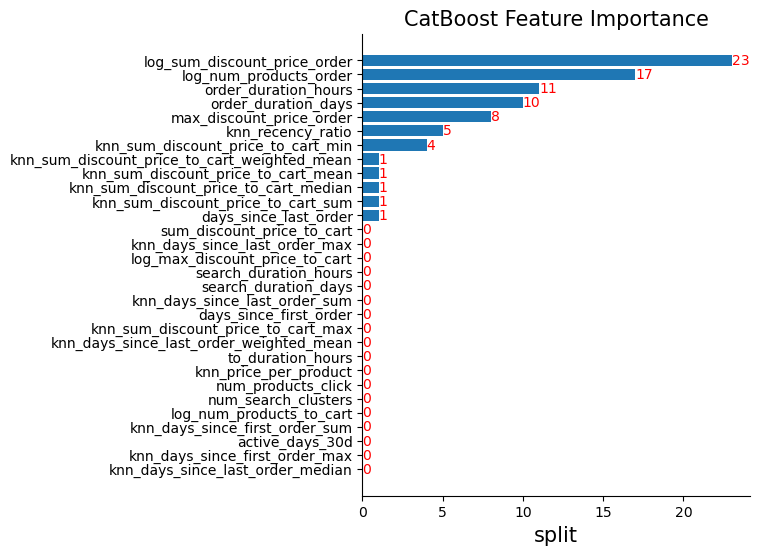

In [19]:
from local_utils import *

print('feature_importance:', catboost_model.feature_importances_, '\n')

plot_catboost_importance(catboost_model, cols, importance_type='split', top_k=30, sklearn_style=True)

In [9]:
from local_utils import *

df_pd = df_pd[df_pd['user_id'] != 2346229]

lgb_tr, lgb_val = get_split(df_pd, val_size=0.25, random_state=41)

cols = list(set(df_pd.columns) - {'user_id', 'target', 'last_click_time', 'first_click_time', 'last_favorite_time', 'first_favorite_time', 
                                  'last_order_time', 'first_order_time', 'last_to_cart_time', 'first_to_cart_time', 'last_search_time', 'first_search_time',
                                  'top3_search_clusters', 'top3_search_counts', 'search_cluster_entropy', 'top3_product_counts', 'product_cluster_entropy', 'top3_product_clusters'})

lgb_params = {
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.01,    # Можно уменьшить до 0.005 для большей точности
    
    'max_depth': 75,
    'num_leaves': 75,
    'min_data_in_leaf': 30,
    
    # Настройки обучения
    'num_iterations': 900,    # Можно увеличить при ранней остановке
    'early_stopping_rounds': 60,
    'seed': 42,               # Для воспроизводимости
    
    # Дополнительно
    'verbose': 1,
    'importance_type': 'split',
}

lgb_model = train_model_new(lgb_tr, lgb_val, cols, 'target', params=lgb_params, shadow_features=False, sklearn_style=True)


[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] early_stopping_round is set=60, early_stopping_rounds=60 will be ignored. Current value: early_stopping_round=60
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Info] Number of positive: 486153, number of negative: 920063
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.284673 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24841
[LightGBM] [Info] Number of data points in the train set: 1406216, number of used features: 124
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] early_stopping_round is set=60, early_stopping_rounds=60 will be ignored. Current value: early_stopping_round=60


feature_importance: [ 515  242  875  222  565  215  406  147 1126  521  732  182  149  305
  282 1679  381  164  177  319  947  841  655  327  288 1051  182  566
  513  276  103  368  143 1731  775   56  475  833 1068 1034  329  150
    5  186  314  434  833  149  115  596  322  359  779  652 1339  390
  807  235  287    3  576    0 1962  960 1504 1420 1578   31  134    0
  673  607   99  422  170  415   38  112  623    0  206  319 1373 1029
  655  445   24  772  355  777  267  163  198 1248 2526  286  358  290
  214   35    0  423    0 1377    5 2351  274  314  252  369  813  503
 1485  728  213   79   74  284   46  486   62 1013  773 1648] 



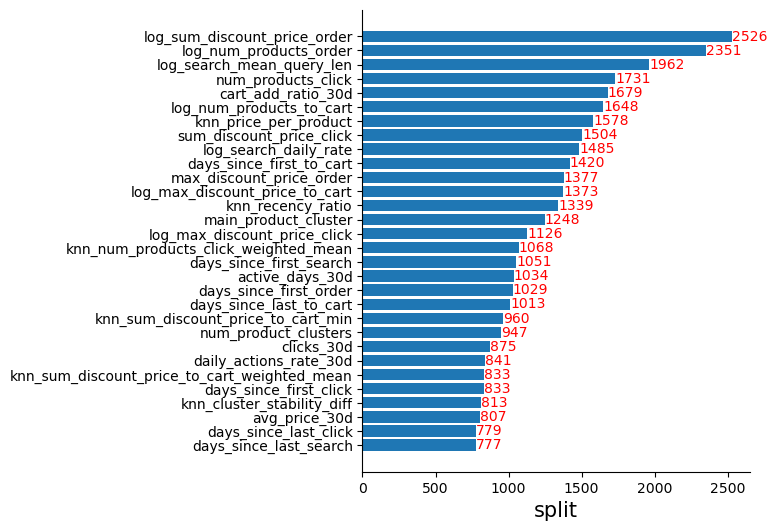

In [10]:
from local_utils import *

print('feature_importance:', lgb_model.feature_importances_, '\n')

plot_lgbm_importance(lgb_model, cols, importance_type='split', top_k=30, sklearn_style=True)

In [11]:
#test_df_pd['catboost_predict'] = catboost_model.predict_proba(test_df_pd[cols])[:, 1]
#test_df_pd['lgb_predict'] = lgb_model.predict_proba(test_df_pd[cols])[:, 1]
test_df_pd['predict'] = lgb_model.predict_proba(test_df_pd[cols])[:, 1]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


In [23]:
test_df_pd['predict'] = test_df_pd[['catboost_predict', 'lgb_predict']].mean(axis=1)

In [12]:
test_df_pd[['user_id', 'predict']]

,user_id,predict
0,1342,0.172848
1,9852,0.789371
2,10206,0.226974
3,11317,0.233373
4,13289,0.669969
...,...,...
2068419,11157283,0.201474
2068420,11160395,0.144858
2068421,11165052,0.593451
2068422,11168218,0.544563


In [13]:
test_df_pd[['user_id', 'predict']].to_csv('good_lgbm.csv', index=False)